# Problem Set 2 Solutions

## 18.330 Intro to Numerical Analysis (MIT, Spring 2019) 

Henrik Ronellenfitsch & Boya Song 

### Problem 1. Adaptive Quadrature (20 points)

In [1]:
using PyPlot
PyPlot.svg(true)

# define basic quadrature rules

function rectangular_rule(f, a, b, N)
    Δ = (b - a)/N
    
    I = 0.0
    for n=0:N-1
        I += Δ*f(a + n*Δ)
    end
    
    return I
end

function trapezoid_rule(f, a, b, N)
    Δ = (b - a)/N
    
    I = 0.5*Δ*f(a) + 0.5*Δ*f(b)
    for n=1:N-1
        I += Δ*f(a + n*Δ)
    end
    
    return I
end

function simpson_rule(f, a, b, N)
    Δ = (b - a)/N
    h = Δ/2
    
    I = h*f(a)/3 + h*f(b)/3
    for n=1:N-1
        I += h*( 2*f(a + 2*n*h) + 4*f(a+ (2*n-1)*h))/3
    end
    I += 4*h*f(a+ (2*N-1)*h)/3
    
    return I
end

simpson_rule (generic function with 1 method)

In [2]:
function adaptive_quad(f, a, b, quad_rule, N, ε; refine_factor=2.0)
    """ Implement recursive adaptive quadrature
    for ∫ₐᵇ f(x) dx using quad_rule.
    
    Integration is stopped when coarse and fine result differ by less than ε.
    """
    Q_coarse = quad_rule(f, a, b, N)
    Q_fine = quad_rule(f, a, b, 2*N)
    
    if abs(Q_fine - Q_coarse) < ε
        return Q_fine
    else
        Q_left = adaptive_quad(f, a, (a+b)/2.0, quad_rule, N, ε; refine_factor=refine_factor)
        Q_right = adaptive_quad(f, (a+b)/2.0, b, quad_rule, N, ε; refine_factor=refine_factor)
        
        return Q_left + Q_right
    end
end

adaptive_quad (generic function with 1 method)

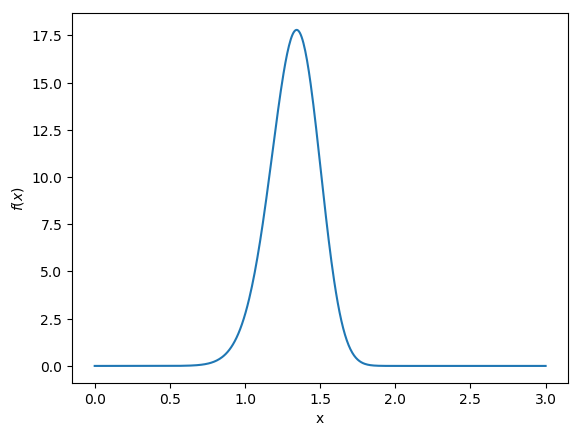

PyObject Text(26.000000000000007, 0.5, '$f(x)$')

In [3]:
# test function
f(x) = x^10*exp(4x^3 - 3x^4)
a = 0.0
b = 3.0

figure()
xs = LinRange(a, b, 500)
plot(xs, f.(xs))
xlabel("x")
ylabel(L"f(x)")

In [4]:
# adaptive integral
exact = simpson_rule(f, a, b, 1e6)

7.258397723462886

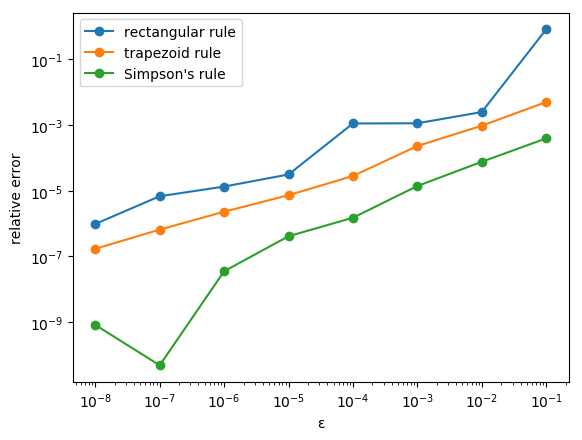

PyObject Text(24.000000000000007, 0.5, 'relative error')

In [5]:
# error analysis

εs = 10.0 .^(-1:-1:-8)

convergence_rect = [abs((adaptive_quad(f, a, b, rectangular_rule, 1, ε) - exact)/exact) for ε in εs]
convergence_trap = [abs((adaptive_quad(f, a, b, trapezoid_rule, 1, ε) - exact)/exact) for ε in εs]
convergence_simp = [abs((adaptive_quad(f, a, b, simpson_rule, 1, ε) - exact)/exact)  for ε in εs]

figure()

loglog(εs, convergence_rect, "o-", label="rectangular rule")
loglog(εs, convergence_trap, "o-", label="trapezoid rule")
loglog(εs, convergence_simp, "o-", label="Simpson's rule")

legend()
xlabel("ε")
ylabel("relative error")


###  Problem 2. ODE solvers and numerical quadrature. (20 points)

#### (a) 
By Fundamental Theorems of Calculus, for any $t\geq a$, 
$$u(t) = \int_a^t \frac{du}{dt}(x) \, dx +u(a)= \int_a^t f(x)\, dx.$$
Therefore $u(b) = \int_a^b f(x)\, dx = \mathcal{I}$. 

#### (b) 
With Euler method we have: 
$$u_{n+1} = u_{n} + h f(x_n) \implies u_{n+1} - u_{n} = \int_{x_n}^{x_{n+1}} f(x)\, dx  =  h f(x_n)$$
which is the same as the rectangle rule. 

With improved Euler method we have: 
$$u_{n+1} = u_{n} + \frac{h}{2}\left(f(x_n)+ f(x_n+h)\right) \implies u_{n+1} - u_{n} = \int_{x_n}^{x_{n+1}} f(x)\, dx  =  \frac{h}{2}\left(f(x_n)+ f(x_n+h)\right)$$
which is the same as the trapezoid rule.


### Problem 3. Error analysis for the midpoint rule (20 points)
Assume that at $t_n$, $u(t_n) = u^{\text{midpoint}}_n = u_n$. Expand $u(t_{n+1}) = u(t_n+h)$ around $t_n$ in Taylor series, we get
\begin{align}
u(t_n+h) &= u(t_n) + h\frac{du}{dt}(t_n) + \frac{h^2}{2}\frac{d^2u}{dt^2}(t_n)+\frac{h^3}{6}\frac{d^3u}{dt^3}(t_n)+\cdots\\
&= u_n + hf(t_n, u_n) + \frac{h^2}{2}\frac{d^2u}{dt^2}(t_n)+O(h^3)
\end{align}

Notice that 
\begin{align}
\frac{d^2u}{dt^2}(t_n) &= \frac{\partial f}{\partial t} (t_n, u_n) + \frac{\partial f}{\partial u} (t_n, u_n) \frac{du}{dt} (t_n, u_n)\\
& =  \frac{\partial f}{\partial t} (t_n, u_n) + \frac{\partial f}{\partial u} (t_n, u_n) f(t_n, u_n)
\end{align}

Expand $f$ in Taylor series, we get
\begin{align}
u^{\text{midpoint}}_{n+1} & = u^{\text{midpoint}}_{n} + hf\left(t_n + \frac{h}{2}, u_n + \frac{h}{2}f(t_n, t_n)\right)\\
&= u_{n} + h \left[ f(t_n, u_n) + \frac{h}{2}\frac{\partial f}{\partial t} (t_n, u_n) + \frac{h}{2} f(t_n, u_n)\frac{\partial f}{\partial u} (t_n, u_n)+O(h^2) \right]\\
&= u_n + hf(t_n, u_n) + \frac{h^2}{2}\left[\frac{\partial f}{\partial t} (t_n, u_n) + \frac{\partial f}{\partial u} (t_n, u_n) f(t_n, u_n)\right]+O(h^3)
\end{align}

Therefore 
$$u(t_n+h) - u^{\text{midpoint}}_{n+1}  = O(h^3)$$
i.e., error per step in the midpoint method is third-order in $h$. Therefore the overall error is second-order in $h$, i.e. the overall error is $O(h^2)$. 

###  Problem 4. Leapfrog integration  (20 points)
#### (a)

In [6]:
# simple Euler method

function euler_method(f, t0, u0, h, N)
    # Integrate u' = f(u) from (t0, u0) using the Euler method with stepsize
    # h and N steps
    
    ts = collect(t0 .+ h*(0:N))
    us = zeros(N + 1, size(u0)[2])

    us[1,:] = u0
    
    for i=1:N
        us[i+1,:] = us[i,:]' + h*f(us[i,:]) 
    end
    
    return ts, us
end

euler_method (generic function with 1 method)

In [7]:
# Solve using Euler method
f(u) = [u[2] -u[1]]
u0 = [0 1]

ts_euler, us_euler = euler_method(f, 0, u0, 0.01, 3000)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  29.91, 29.92, 29.93, 29.94, 29.95, 29.96, 29.97, 29.98, 29.99, 30.0], [0.0 1.0; 0.01 1.0; … ; -1.14976 0.166568; -1.1481 0.178065])

In [8]:
# Exact solution
u(t) = [sin(t) cos(t)]
ts_exact = LinRange(0, 30, 500)

u_exact = vcat(u.(ts_exact)...);

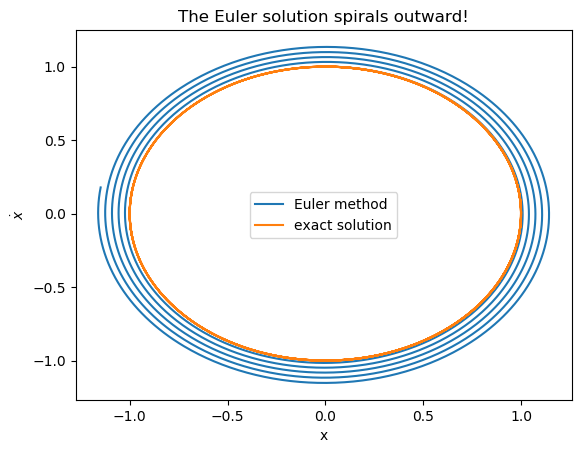

PyObject <matplotlib.legend.Legend object at 0x14a8d04e0>

In [9]:
figure()

plot(us_euler[:,1], us_euler[:,2], "-", label="Euler method")
plot(u_exact[:,1], u_exact[:,2], "-", label="exact solution")

xlabel("x")
ylabel(L"\dot{x}")
title("The Euler solution spirals outward!")
legend()

#### (b)

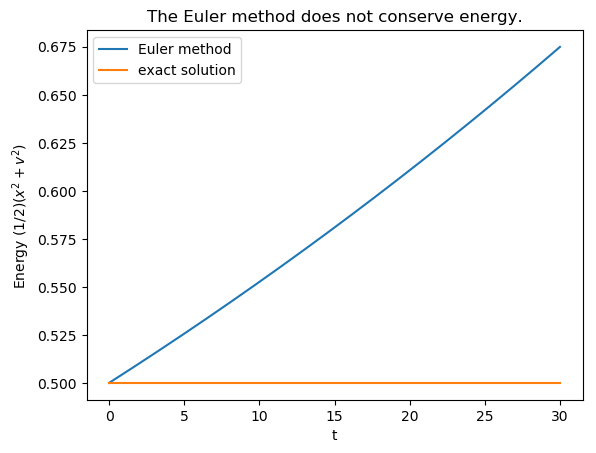

PyObject <matplotlib.legend.Legend object at 0x14a757f98>

In [10]:
figure()

plot(ts_euler, 0.5*(us_euler[:,1].^2 + us_euler[:,2].^2), "-", label="Euler method")
plot(ts_exact, 0.5*(u_exact[:,1].^2 + u_exact[:,2].^2), "-", label="exact solution")

xlabel("t")
ylabel(L"Energy $(1/2)(x^2 + v^2)$ ")
title("The Euler method does not conserve energy.")
legend()

#### (c)

In [11]:
function leapfrog(F, t0, u0, h, N)
    """ The Leapfrog method for integrating Newton's law
    """
    
    ts = collect(t0 .+ h*(0:N))
    us = zeros(N + 1, size(u0)[2])

    us[1,:] = u0
    
    for i=1:N
        # v_{n+1/2}
        v12 = us[i,2:2:end] + h/2 * F(us[i,1:2:end])
        
        # x_{n}
        us[i+1,1:2:end] = us[i,1:2:end] + h*v12 
        
        # v_{n}
        us[i+1,2:2:end] = v12 + h/2*F(us[i+1,1:2:end])
    end
    
    return ts, us
end

leapfrog (generic function with 1 method)

In [12]:
# integrate using Leapfrog method
F(x) = -x
u0 = [0 1]

ts_lf, us_lf = leapfrog(F, 0, u0, 0.1, 300)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  29.1, 29.2, 29.3, 29.4, 29.5, 29.6, 29.7, 29.8, 29.9, 30.0], [0.0 1.0; 0.1 0.995; … ; -0.998983 0.0672913; -0.987259 0.166603])

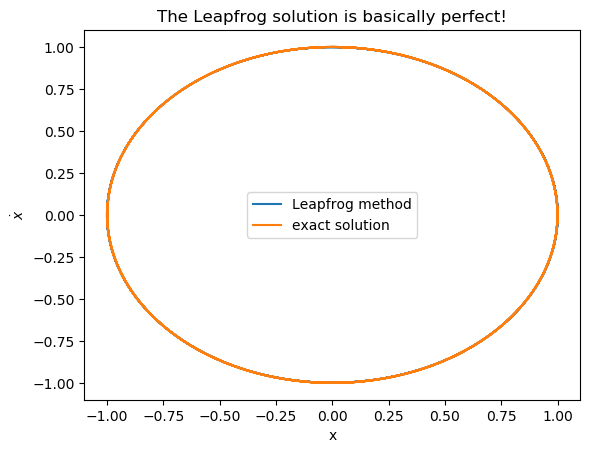

PyObject <matplotlib.legend.Legend object at 0x14aa5c588>

In [13]:
figure()

plot(us_lf[:,1], us_lf[:,2], "-", label="Leapfrog method")
plot(u_exact[:,1], u_exact[:,2], "-", label="exact solution")

xlabel("x")
ylabel(L"\dot{x}")
title("The Leapfrog solution is basically perfect!")
legend()

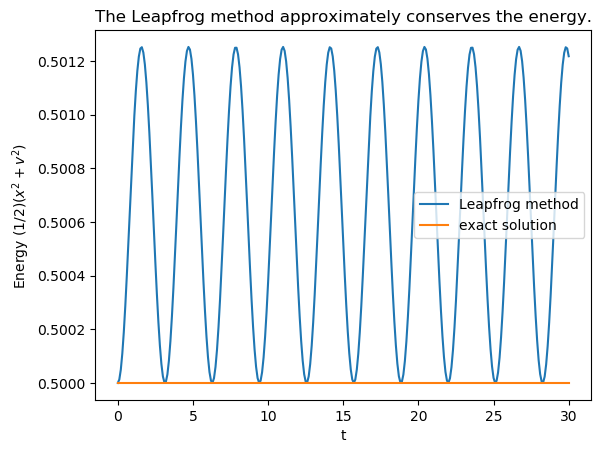

PyObject <matplotlib.legend.Legend object at 0x14a7c38d0>

In [14]:
figure()

plot(ts_lf, 0.5*(us_lf[:,1].^2 + us_lf[:,2].^2), "-", label="Leapfrog method")
plot(ts_exact, 0.5*(u_exact[:,1].^2 + u_exact[:,2].^2), "-", label="exact solution")

xlabel("t")
ylabel(L"Energy $(1/2)(x^2 + v^2)$ ")
title("The Leapfrog method approximately conserves the energy.")
legend()

#### (d)

In [15]:
# Integrate backward in time
f(u) = [u[2] -u[1]]
u0 = us_euler[end,:]'

ts_backward_euler, us_backward_euler = euler_method(f, 30, u0, -0.01, 3000)

([30.0, 29.99, 29.98, 29.97, 29.96, 29.95, 29.94, 29.93, 29.92, 29.91  …  0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.0], [-1.1481 0.178065; -1.14988 0.166584; … ; 0.013497 1.3497; -3.96558e-15 1.34984])

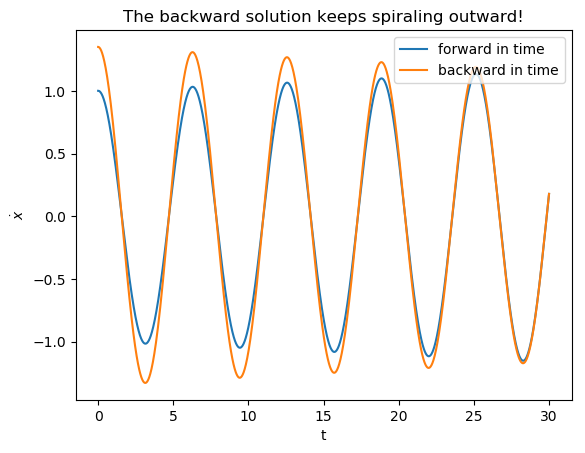

PyObject <matplotlib.legend.Legend object at 0x14b074cf8>

In [16]:
figure()

plot(ts_euler, us_euler[:,2], "-", label="forward in time")
plot(ts_backward_euler, us_backward_euler[:,2], "-", label="backward in time")

xlabel("t")
ylabel(L"\dot{x}")
title("The backward solution keeps spiraling outward!")
legend()

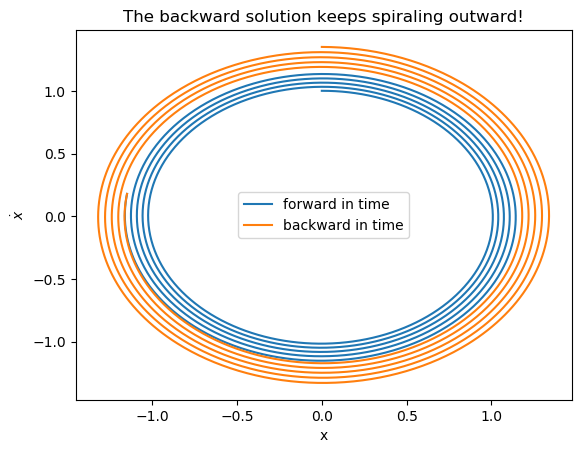

PyObject <matplotlib.legend.Legend object at 0x14a7fb7f0>

In [17]:
figure()

plot(us_euler[:,1], us_euler[:,2], "-", label="forward in time")
plot(us_backward_euler[:,1], us_backward_euler[:,2], "-", label="backward in time")

xlabel("x")
ylabel(L"\dot{x}")
title("The backward solution keeps spiraling outward!")
legend()

In [18]:
# backward leapfrog

u0 = us_lf[end,:]'
ts_backward_lf, us_backward_lf = leapfrog(F, 30, u0, -0.1, 300)

([30.0, 29.9, 29.8, 29.7, 29.6, 29.5, 29.4, 29.3, 29.2, 29.1  …  0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0], [-0.987259 0.166603; -0.998983 0.0672913; … ; 0.1 0.995; 8.88178e-16 1.0])

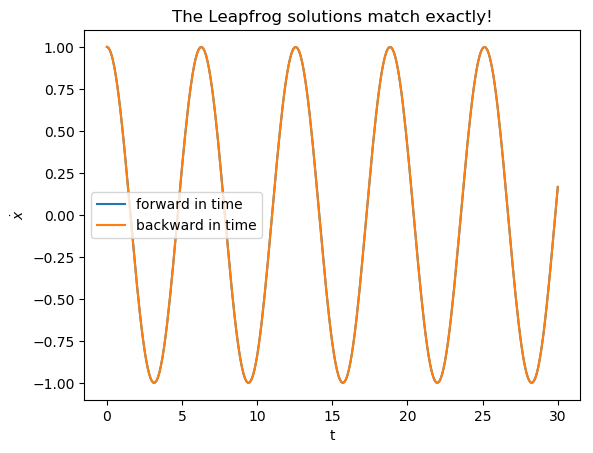

PyObject <matplotlib.legend.Legend object at 0x14a7bff60>

In [19]:
figure()

plot(ts_lf, us_lf[:,2], "-", label="forward in time")
plot(ts_backward_lf, us_backward_lf[:,2], "-", label="backward in time")

xlabel("t")
ylabel(L"\dot{x}")
title("The Leapfrog solutions match exactly!")
legend()

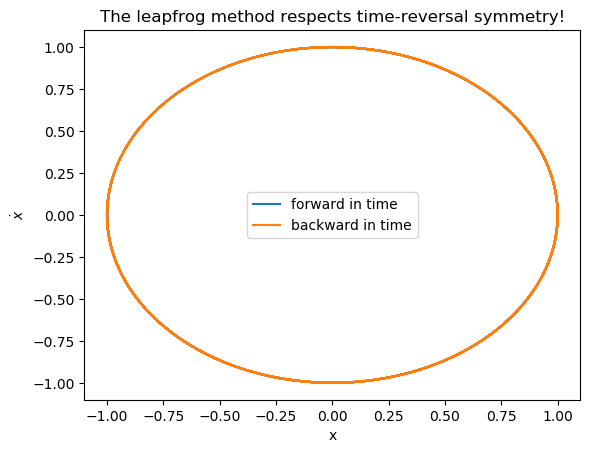

PyObject <matplotlib.legend.Legend object at 0x14b3b2a20>

In [20]:
figure()

plot(us_lf[:,1], us_lf[:,2], "-", label="forward in time")
plot(us_backward_lf[:,1], us_backward_lf[:,2], "-", label="backward in time")

xlabel("x")
ylabel(L"\dot{x}")
title("The leapfrog method respects time-reversal symmetry!")
legend()

#### (e)
Let's check whether the Leapfrog method or the Euler method satisfy
time-reversal symmetry.
This symmetry means that the result of applying the rule forward in time
and then backward in time brings us back to the initial condition.

Let's check the Euler method first. The iteration rule is
$$
u_{n+1} = u_{n} + h f(t_n, u_n).
$$

Clearly, we only need to check only one step.

So, starting from $u_0$, we find forward in time,
$$
u_1 = u_0 + h f(t_0, u_0).
$$

Now we apply the rule backward, with $h\rightarrow -h$:

$$
u_2 = u_1 -h f(t_1, u_1) = u_0 + h f(t_0, u_0) - h f(t_0 + h, u_0 + h f(t_0, u_0)) \neq u_0.
$$
So the Euler method does not respect time-reversal symmetry.

Before we check the Leapfrog method, let us rewrite it by eliminating the half-step velocity,
\begin{align}
    x_{n+1} &= x_n + h\, v_{n} + \frac{h^2}{2} F(x_n) \\
    v_{n+1} &= v_{n} + \frac{h}{2} \left( F(x_n) + F(x_{n+1}) \right).
\end{align}

Let's take one forward step,
\begin{align}
    x_{1} &= x_0 + h\, v_{0} + \frac{h^2}{2} F(x_0) \\
    v_{1} &= v_{0} + \frac{h}{2} \left( F(x_0) + F(x_{1}) \right).
\end{align}

And one backward step with $h\rightarrow -h$:
\begin{align}
    x_{2} &= x_1 + h\, v_1 + \frac{h^2}{2} F(x_1) = x_0 + h\, v_{0} + \frac{h^2}{2} F(x_0)
        -h v_{0} - \frac{h^2}{2} \left( F(x_0) + F(x_{1}) \right) + \frac{h^2}{2} F(x_1) = x_0 \\
    v_{2} &= v_{1} + \frac{h}{2} \left( F(x_1) + F(x_{2}) \right) =
        v_{0} + \frac{h}{2} \left( F(x_0) + F(x_{1}) \right) - \frac{h}{2} \left( F(x_1) + F(x_0) \right) = v_0.
\end{align}

So the Leapfrog method does respect time-reversal symmetry.

## Problem 5. Choreographed Orbits

Let the position vectors of the three planets be $\mathbf{r}_{1,2,3}$.
Define
$$
\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j, \quad r_{ij} = |\mathbf{r}_{ij}|, 
\quad \hat{\mathbf{r}}_{ij} = \frac{\mathbf{r}_{ij}}{r_{ij}}.
$$

Newton's laws of motion for the first planet are then,
$$
m \ddot{\mathbf{r}}_1 = -\frac{G m^2}{r_{12}^2} \hat{\mathbf{r}}_{12} -\frac{G m^2}{r_{13}^2} \hat{\mathbf{r}}_{13},
$$ 

and cyclically permuted for the others. Setting $Gm=1$, we rewrite the equations,

\begin{align}
\ddot{\mathbf{r}}_1 &= -\frac{\mathbf{r}_{12}}{r_{12}^3} -\frac{\mathbf{r}_{13}}{r_{13}^3} \\
\ddot{\mathbf{r}}_2 &= -\frac{\mathbf{r}_{21}}{r_{21}^3} -\frac{\mathbf{r}_{23}}{r_{23}^3} \\
\ddot{\mathbf{r}}_3 &= -\frac{\mathbf{r}_{31}}{r_{31}^3} -\frac{\mathbf{r}_{32}}{r_{32}^3}.
\end{align}

To use the Leapfrog method, we realize that in the $x$-$y$ plane,
$$
r_{ij} = \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2},
$$
and therefore, the forces are in components
\begin{align}
F_{1,x} &= -\frac{x_1 - x_2}{r_{12}^3} - \frac{x_1 - x_3}{r_{13}^3} \\
F_{1,y} &= -\frac{y_1 - y_2}{r_{12}^3} - \frac{y_1 - y_3}{r_{13}^3} \\
F_{2,x} &= -\frac{x_2 - x_1}{r_{21}^3} - \frac{x_2 - x_3}{r_{23}^3} \\
F_{2,y} &= -\frac{y_2 - y_1}{r_{21}^3} - \frac{y_2 - y_3}{r_{23}^3} \\
F_{3,x} &= -\frac{x_3 - x_1}{r_{31}^3} - \frac{x_3 - x_2}{r_{32}^3} \\
F_{3,y} &= -\frac{y_3 - y_1}{r_{31}^3} - \frac{y_3 - y_2}{r_{32}^3}
\end{align}

In [21]:
# Three-body problem
function F_3body(u)
    x1, y1, x2, y2, x3, y3 = u
    
    r12_3 = ( (x1 - x2)^2 + (y1 - y2)^2 )^(3/2)
    r13_3 = ( (x1 - x3)^2 + (y1 - y3)^2 )^(3/2)
    r23_3 = ( (x2 - x3)^2 + (y2 - y3)^2 )^(3/2)
    
    return [
        -(x1 - x2)/r12_3 - (x1 - x3)/r13_3,
        -(y1 - y2)/r12_3 - (y1 - y3)/r13_3,
        -(x2 - x1)/r12_3 - (x2 - x3)/r23_3,
        -(y2 - y1)/r12_3 - (y2 - y3)/r23_3,
        -(x3 - x1)/r13_3 - (x3 - x2)/r23_3,
        -(y3 - y1)/r13_3 - (y3 - y2)/r23_3
    ]
end

F_3body (generic function with 1 method)

In [22]:
# Solve using the Leapfrog method
u0 = [-0.7 0.99 0.35 0.078 1.1 0.1 -0.07 0.47 -0.4 -1.1 -0.3 -0.53]

h = 0.01
t_end = 20.0
N = Int64(t_end/h)

ts_3body, us_3body = leapfrog(F_3body, 0, u0, h, N)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], [-0.7 0.99 … -0.3 -0.53; -0.690045 1.00081 … -0.305208 -0.511422; … ; -0.70207 0.981634 … -0.0588164 -0.337557; -0.692209 0.990382 … -0.0621009 -0.31911])

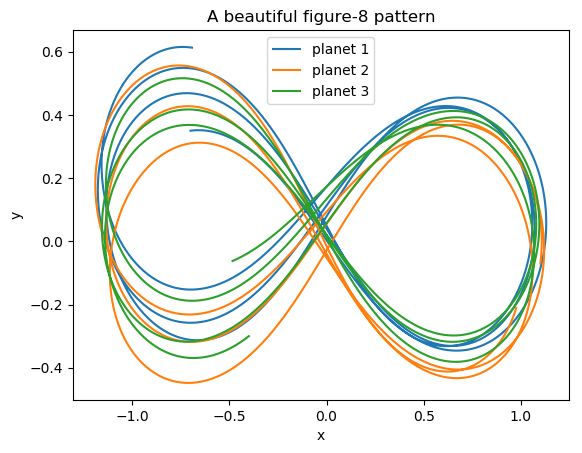

PyObject <matplotlib.legend.Legend object at 0x14b399b38>

In [23]:
# Plot the solution
figure()

plot(us_3body[:,1], us_3body[:,3], label="planet 1")
plot(us_3body[:,5], us_3body[:,7], label="planet 2")
plot(us_3body[:,9], us_3body[:,11], label="planet 3")

xlabel("x")
ylabel("y")
title("A beautiful figure-8 pattern")
legend()

In [24]:
# Let's use the manipulate macro to visualize the orbits in time
using Interact

timer = Observable(1)
@async while true
    sleep(0.05)
    timer[] = timer[] + 2
    if timer[] > size(us_3body)[1]
        timer[] = 1
    end
end

f_h = figure()

@manipulate for i=timer; withfig(f_h) do
        plot(us_3body[i,1], us_3body[i,3], "o", label="planet 1")
        plot(us_3body[i,5], us_3body[i,7], "o", label="planet 2")
        plot(us_3body[i,9], us_3body[i,11], "o", label="planet 3")
        
        xlabel("x")
        ylabel("y")
        xlim(-1.5, 1.5)
        ylim(-1.5, 1.5)
        legend()
    end
end

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/e54c8154f3f0519ca67ad59f36ee64592fdd8dd2-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/e54c8154f3f0519ca67ad59f36ee64592fdd8dd2-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:observable,Int64}(OrderedDict{Symbol,Any}(:label=>"i"), Observable{Int64} with 1 listeners. Value:
1, nothing, ##145#146())), Observable{Any} with 0 listeners. Value:
Figure(PyObject <Figure size 640x480 with 1 Axes>), nothing, getfield(InteractBase, Symbol("##142#143"))())

In [25]:
# Change initial conditions by a little bit
u0_new = copy(u0)
u0_new[1] *= 1.25
u0_new[3] *= 0.75

h = 0.01
t_end = 20.0
N = Int64(t_end/h)

ts_3body, us_3body = leapfrog(F_3body, 0, u0_new, h, N)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], [-0.875 0.99 … -0.3 -0.53; -0.865028 1.00432 … -0.305226 -0.514906; … ; -22.3072 -25.5461 … -4.98504 -5.39638; -22.5626 -25.546 … -5.039 -5.39637])

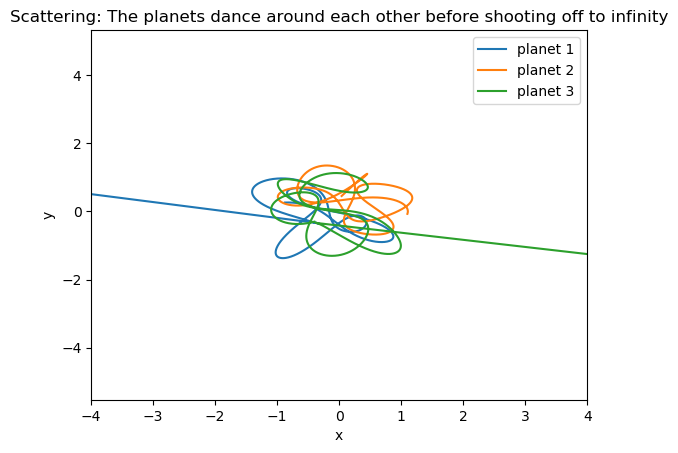

PyObject <matplotlib.legend.Legend object at 0x14b776e10>

In [26]:
# Plot the solution
figure()

plot(us_3body[:,1], us_3body[:,3], label="planet 1")
plot(us_3body[:,5], us_3body[:,7], label="planet 2")
plot(us_3body[:,9], us_3body[:,11], label="planet 3")

xlim(-4, 4)
xlabel("x")
ylabel("y")
title("Scattering: The planets dance around each other before shooting off to infinity")
legend()

In [27]:
# Change initial conditions by a little bit again
u0_new = copy(u0)
u0_new[6] *= 1.25
u0_new[3] *= 0.75
u0_new[9] *= 0.75

h = 0.01
t_end = 20.0
N = Int64(t_end/h)

ts_3body, us_3body = leapfrog(F_3body, 0, u0_new, h, N)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], [-0.7 0.99 … -0.3 -0.53; -0.690025 1.00498 … -0.30521 -0.511723; … ; 18.4748 1.49619 … -15.8012 -1.24136; 18.4897 1.49617 … -15.8136 -1.24135])

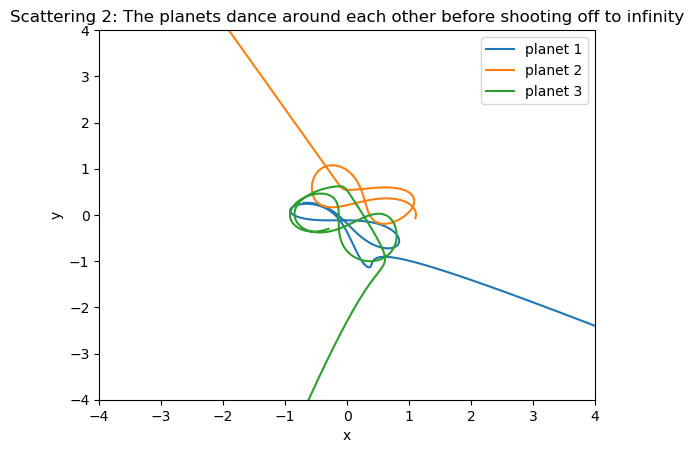

PyObject <matplotlib.legend.Legend object at 0x14c3a34a8>

BoundsError: attempt to access 2001×12 Array{Float64,2} at index [2003, 1]
Stacktrace:
 [1] getindex(::Array{Float64,2}, ::Int64, ::Int64) at ./array.jl:730
 [2] (::getfield(Main, Symbol("##13#15")){Int64})() at ./In[24]:16
 [3] #withfig#209(::Bool, ::Function, ::getfield(Main, Symbol("##13#15")){Int64}, ::Figure) at /Users/boyasong/.julia/packages/PyPlot/mQXSC/src/PyPlot.jl:284
 [4] withfig at /Users/boyasong/.julia/packages/PyPlot/mQXSC/src/PyPlot.jl:276 [inlined]
 [5] (::getfield(Main, Symbol("##12#14")))(::Int64) at ./In[24]:15
 [6] #16 at /Users/boyasong/.julia/packages/Observables/qCJWB/src/Observables.jl:152 [inlined]
 [7] (::getfield(Observables, Symbol("#g#15")){getfield(Observables, Symbol("##16#17")){getfield(Main, Symbol("##12#14")),Observable{Any}},Tuple{Observable{Int64}}})(::Int64) at /Users/boyasong/.julia/packages/Observables/qCJWB/src/Observables.jl:136
 [8] #setindex!#1(::getfield(Observables, Symbol("##2#4")), ::Function, ::Observable{Int64}, ::Int64) at /Users/boya

In [28]:
# Plot the solution
figure()

plot(us_3body[:,1], us_3body[:,3], label="planet 1")
plot(us_3body[:,5], us_3body[:,7], label="planet 2")
plot(us_3body[:,9], us_3body[:,11], label="planet 3")

xlim(-4, 4)
ylim(-4, 4)
xlabel("x")
ylabel("y")
title("Scattering 2: The planets dance around each other before shooting off to infinity")
legend()